#### Predection PAs
<small> only looking at the prior season

In [34]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [35]:
pa_data = pd.read_csv('./data/cleaned/pa_injury_data.csv')
pa_data = pa_data.drop(columns=['Unnamed: 0'])

#### Normalize

In [36]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: pa_data.loc[x, 'PA']))
        return avg

In [37]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: pa_data.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: pa_data.loc[x, 'PA']))
    return np.sqrt(variance)

In [38]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

mean

In [39]:
# df to store mean results
mean_values = pd.DataFrame(index=pa_data['Season'].unique())

for col in pa_data.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = pa_data.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,Days_Missed_Season
0,2021,434.346692,28.345488,19.442491
1,2022,435.463773,28.218533,15.497272
2,2023,447.218444,27.997785,15.346808
3,2024,448.020185,27.943522,14.225845


std

In [40]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=pa_data['Season'].unique())

# Loop through numeric columns
for col in pa_data.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = pa_data.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,Days_Missed_Season
0,2021,180.319863,3.494339,27.970918
1,2022,179.018156,3.647183,25.618067
2,2023,183.947149,3.720606,25.160594
3,2024,180.852846,3.629216,25.591939


zscore

In [41]:
df_zscore = z_scores(pa_data, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,Days_Missed_Season
0,aaron hicks,2021,82.900015,107.596608,144.173562
1,aaron hicks,2022,100.979578,110.368185,93.950647
2,aaron hicks,2023,92.649060,113.444624,109.003441
3,aaron hicks,2024,78.710858,116.688116,94.441279
4,aaron judge,2021,111.016718,101.873065,96.981690


#### xgboost model

In [42]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

get next year PA

In [43]:
for idx in df_zscore.index:
    # retrive name, season
    name = df_zscore.loc[idx, 'Name']
    season = df_zscore.loc[idx, 'Season']
    # full df
    next_year = pa_data[(pa_data['Name'] == name) & (pa_data['Season'] == season + 1)]
    # add to df
    if not next_year.empty:
        df_zscore.loc[idx, 'next_pa'] = next_year['PA'].iloc[0] # need for later anaylsis

df_zscore_train = df_zscore.dropna(subset=['next_pa'])


#### model training loop

In [44]:
X = df_zscore_train.drop(columns=['Name', 'Season', 'next_pa'])
y = df_zscore_train['next_pa']

In [45]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [46]:
model = xgb.XGBRegressor(n_estimators = 100, random_state = 26)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=26, ...)

##### hyperparameter search

random search

In [47]:
from sklearn.model_selection import RandomizedSearchCV

In [48]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=1000, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search_params = {
    'learning_rate': [0.1, 0.15],   
    'max_leaves': [ 16, 17, 18, 19, 20],
    'min_child_weight': [20, 22, 24],      
    'subsample': [0.9, 0.95],           
    'colsample_bytree':[0.8, 0.9, 1],     
    'early_stopping_rounds':[30, 40, 50],
    'max_depth': [2, 3, 4]
}
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
[0]	validation_0-rmse:10.76222
[1]	validation_0-rmse:10.31133
[2]	validation_0-rmse:9.94484
[3]	validation_0-rmse:9.67356
[4]	validation_0-rmse:9.45198
[5]	validation_0-rmse:9.27742
[6]	validation_0-rmse:9.18325
[7]	validation_0-rmse:9.06110
[8]	validation_0-rmse:8.98446
[9]	validation_0-rmse:8.92320
[10]	validation_0-rmse:8.85681
[11]	validation_0-rmse:8.81350
[12]	validation_0-rmse:8.79312
[13]	validation_0-rmse:8.76866
[14]	validation_0-rmse:8.73393
[15]	validation_0-rmse:8.69958
[16]	validation_0-rmse:8.68059
[17]	validation_0-rmse:8.65161
[18]	validation_0-rmse:8.64964
[19]	validation_0-rmse:8.63379
[20]	validation_0-rmse:8.59628
[21]	validation_0-rmse:8.57674
[22]	validation_0-rmse:8.54153
[23]	validation_0-rmse:8.54605
[24]	validation_0-rmse:8.53683
[25]	validation_0-rmse:8.50874
[26]	validation_0-rmse:8.52197
[27]	validation_0-rmse:8.49837
[28]	validation_0-rmse:8.49689
[29]	validation_0-rmse:8.48612
[30]	validati

In [49]:
opti_para = {'colsample_bytree': 1, 'early_stopping_rounds': 30, 'learning_rate': 0.15, 'max_depth': 2, 'max_leaves': 16, 'min_child_weight': 22, 'subsample': 0.9}
model.set_params(**opti_para)
model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

[0]	validation_0-rmse:193.42626
[1]	validation_0-rmse:184.94981
[2]	validation_0-rmse:178.28070
[3]	validation_0-rmse:173.27410
[4]	validation_0-rmse:169.69782
[5]	validation_0-rmse:167.06545
[6]	validation_0-rmse:164.64451
[7]	validation_0-rmse:162.89275
[8]	validation_0-rmse:161.23881
[9]	validation_0-rmse:159.53945
[10]	validation_0-rmse:158.71674
[11]	validation_0-rmse:158.52701
[12]	validation_0-rmse:158.36904
[13]	validation_0-rmse:157.70314
[14]	validation_0-rmse:156.95741
[15]	validation_0-rmse:156.73209
[16]	validation_0-rmse:156.27359
[17]	validation_0-rmse:155.98540
[18]	validation_0-rmse:155.90584
[19]	validation_0-rmse:155.80276
[20]	validation_0-rmse:155.56387
[21]	validation_0-rmse:155.42472
[22]	validation_0-rmse:154.96977
[23]	validation_0-rmse:154.90770
[24]	validation_0-rmse:155.26899
[25]	validation_0-rmse:155.46191
[26]	validation_0-rmse:155.28064
[27]	validation_0-rmse:155.07663
[28]	validation_0-rmse:154.82322
[29]	validation_0-rmse:154.64551
[30]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=30, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=16, min_child_weight=22, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=26, ...)

##### results

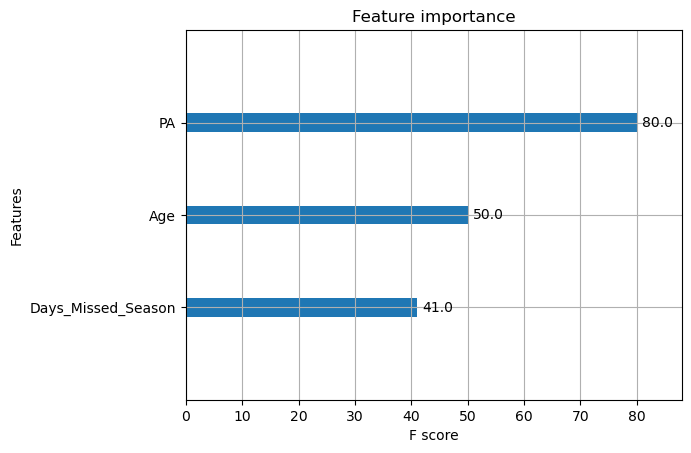

In [50]:
xgb.plot_importance(model)
plt.show()

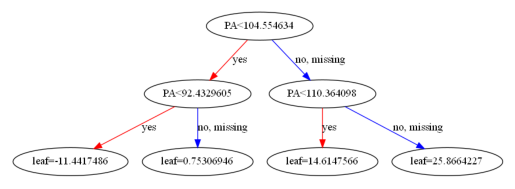

In [51]:
xgb.plot_tree(model, num_trees=3)
plt.show()

In [52]:
results = model.predict(test_x)
rmse = root_mean_squared_error(y_pred=results, y_true=test_y)
r2 = r2_score(test_y, results)

print(rmse)
print(r2)

154.52937650264263
0.42211215018116854


2025 Predections

In [53]:
pred_2025 = df_zscore[df_zscore['Season'] == 2024]
x_predections = pred_2025.drop(columns=['Name', 'Season', 'next_pa'])
xgb_final_preds = model.predict(x_predections)

In [54]:
pred_2025['pred_pa'] = xgb_final_preds
pred_2025 = pred_2025.drop(columns=['next_pa'])
export_pred = pred_2025[['Name', 'pred_pa']]
export_pred = export_pred.reset_index()
export_pred = export_pred.drop(columns='index')
export_pred.to_csv('./data/2025_Predections/pa_25_1.csv')

C:\Users\dalto\AppData\Local\Temp\ipykernel_18372\698028320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_2025['pred_pa'] = xgb_final_preds
